# Pandas Loan Book Analysis
MASTIX Studio can be executed in batch mode to produce results in formats like CSV for subsequent analysis. This notebook demonstrates some fundamental analyses of output from a loan book calculation. The data is loaded into Pandas DataFrames and visualized using Seaborn.

## Loan Book Specification
The loan book has been generated and comprises 400,000 loans: 200,000 in SEK (Swedish krona) and 200,000 in NOK (Norwegian krone). For each currency, half of the loans are fixed-rate while the other half are floating rate.

## Calculations
MASTIX Studio computes all the cash flows for the loans in forward terms, along with their sensitivities to interest rate fluctuations. The FX rates and discount factors are provided separately. To combine the dataframes and ensure accurate management and propagation of all sensitivities, the *MASTIX Python Utils* are employed.

#### Import libraries

In [1]:
import sys
import numpy as np
import pandas as pd
from mastixpy import Value

In [2]:
mastix_path = sys.path.append("C:\\MASTIX Studio\\")
data_path = "C:\\Data\\"
sys.path.append(mastix_path)

#### Load Data

The CSV files containing cash flows, discount factors, and FX rates are loaded into Pandas DataFrames.

In [4]:
%%time

sekCashFlows = pd.read_csv(data_path + 'SEK_CashFlows_20220816.csv', delimiter=';', decimal=',', parse_dates=[3])
nokCashFlows = pd.read_csv(data_path + 'NOK_CashFlows_20220816.csv', delimiter=';', decimal=',', parse_dates=[3])

sekDiscountFactors = pd.read_csv(data_path + 'SEK_Discount_Factors_20220816.csv', delimiter=';', decimal=',', index_col=0, parse_dates=[0])
nokDiscountFactors = pd.read_csv(data_path + 'NOK_Discount_Factors_20220816.csv', delimiter=';', decimal=',', index_col=0, parse_dates=[0])

fxRates = pd.read_csv(data_path + 'Fx_Rates_20220816.csv', delimiter=';', decimal=',', index_col=0, usecols=lambda x: x != 'Price Currency')

CPU times: total: 2.12 s
Wall time: 3.28 s


#### Format the DataFrames
The column name representing the cash flow amount is updated to a more descriptive label.

In [5]:
sekCashFlows.rename(columns={'Amount': 'Forward Value (Currency)'}, inplace=True)
nokCashFlows.rename(columns={'Amount': 'Forward Value (Currency)'}, inplace=True)

Derivatives can be retrieved in a specified order by defining the sequence in an array.

In [6]:
preferred_derivatives_order = ['SEK Appreciation', 'NOK Appreciation', 'USD Appreciation',
                               'USDNOK Fx Spot Rate', 'USDSEK Fx Spot Rate',
                               'SEK.DSC.1D', 'SEK.DSC.1W', 'SEK.DSC.2W', 'SEK.DSC.1M', 'SEK.DSC.2M',
                               'SEK.DSC.3M', 'SEK.DSC.6M', 'SEK.DSC.1Y', 'SEK.DSC.2Y', 'SEK.DSC.3Y',
                               'SEK.DSC.5Y', 'SEK.DSC.10Y', 'SEK.DSC.15Y', 'SEK.DSC.20Y', 'SEK.DSC.30Y',
                               'NOK.DSC.1D', 'NOK.DSC.1W', 'NOK.DSC.2W', 'NOK.DSC.1M', 'NOK.DSC.2M',
                               'NOK.DSC.3M', 'NOK.DSC.6M', 'NOK.DSC.1Y', 'NOK.DSC.2Y', 'NOK.DSC.3Y',
                               'NOK.DSC.5Y', 'NOK.DSC.10Y', 'NOK.DSC.15Y', 'NOK.DSC.20Y', 'NOK.DSC.30Y'
                               'USD.DSC.1D', 'USD.DSC.1M', 'USD.DSC.1W', 'USD.DSC.2W',
                               'SEK.3M.1D', 'SEK.3M.1W', 'SEK.3M.2W', 'SEK.3M.1M', 'SEK.3M.2M',
                               'SEK.3M.3M', 'SEK.3M.6M', 'SEK.3M.1Y', 'SEK.3M.2Y', 'SEK.3M.3Y',
                               'SEK.3M.5Y', 'SEK.3M.10Y', 'SEK.3M.15Y', 'SEK.3M.20Y', 'SEK.3M.30Y',
                               'NOK.3M.1D', 'NOK.3M.1W', 'NOK.3M.2W', 'NOK.3M.1M', 'NOK.3M.2M',
                               'NOK.3M.3M', 'NOK.3M.6M', 'NOK.3M.1Y', 'NOK.3M.2Y', 'NOK.3M.3Y',
                               'NOK.3M.5Y', 'NOK.3M.10Y', 'NOK.3M.15Y', 'NOK.3M.20Y', 'NOK.3M.30Y']

#### Perform Calculations on DataFrames
Initially, the cash flows are associated with the corresponding discount factors and FX rates.

In [7]:
%%time

sek_cf_df = Value(sekCashFlows[['Pay']].merge(sekDiscountFactors, left_on='Pay', right_index=True), 'Discount Factor', sekDiscountFactors.columns[1:])
nok_cf_df = Value(nokCashFlows[['Pay']].merge(nokDiscountFactors, left_on='Pay', right_index=True), 'Discount Factor', nokDiscountFactors.columns[1:])

sek_cf_fx = Value(sekCashFlows[['Currency']].merge(fxRates, left_on='Currency', right_index=True), 'Fx Rate', fxRates.columns[1:])
nok_cf_fx = Value(nokCashFlows[['Currency']].merge(fxRates, left_on='Currency', right_index=True), 'Fx Rate', fxRates.columns[1:])

sek_cf_df_SEK = Value(sekCashFlows[['Pay']].merge(sekDiscountFactors, left_on='Pay', right_index=True), 'Discount Factor', sekDiscountFactors.columns[1:])
nok_cf_df_SEK = Value(nokCashFlows[['Pay']].merge(sekDiscountFactors, left_on='Pay', right_index=True), 'Discount Factor', sekDiscountFactors.columns[1:])

CPU times: total: 1.25 s
Wall time: 1.57 s


Using the **MASTIX Python Utils**, we calculate the following:

- The present value in currency \( $PV_{ccy}$ \)
- Present value in SEK \( $PV_{SEK}$ \)
- Forward value in SEK \( $FV_{SEK}$ \)

The relationship between these values can be represented by the following formulas:

\begin{align*}
FV_{ccy} &= a_{ccy} \\
PV_{ccy} &= FV_{ccy}  DF_{ccy} \\
PV_{SEK} &= PV_{ccy}  FX_{ccy,SEK} \\
FV_{SEK} &= \frac{PV_{SEK}}{DF_{SEK}}, \\
\end{align*}

where:
- $DF_{SEK}$ is the discount factor in $\textrm{SEK}$.
- $FX_{ccy,SEK}$ is the exchange rate from $\textrm{ccy}$ to $\textrm{SEK}$.

The MASTIX Python utils library ensures the propagation of sensitivities when performing operations on the DataFrames. The sensitivities propagate according to:

\begin{align*}
\frac{dFV^{\textrm{ccy}}}{dx} & = \frac{da^{\textrm{ccy}}}{dx} \\
\frac{dPV^{\textrm{ccy}}}{dx} & = \frac{dFV^{\textrm{ccy}}}{dx} DF^{\textrm{ccy}} + FV^{\textrm{ccy}} \frac{dDF^{\textrm{ccy}}}{dx} \\
\frac{dPV^{\textrm{SEK}}}{dx} & = \frac{dPV^{\textrm{ccy}}}{dx} FX^{\textrm{ccy},\textrm{SEK}}  + PV^{\textrm{ccy}} \frac{dFX^{\textrm{ccy},\textrm{SEK}}}{dx} \\
\frac{dFV^{\textrm{SEK}}}{dx} & = \frac{dPV^{\textrm{SEK}} }{dx} \frac{1}{DF^{\textrm{SEK}}} - PV^{\textrm{SEK}}  \frac{1}{(DF^{\textrm{SEK}})^2} \frac{dDF^{\textrm{SEK}}}{dx}.
\end{align*}

The DataFrames are wrapped into MASTIX Python objects and the values are calculated.

In [8]:
%%time

sek_cf_fv = Value(sekCashFlows, 'Forward Value (Currency)', sekCashFlows.columns[6:], ['Trade Id', 'Cash Flow', 'Pay'], preferred_derivatives_order)
nok_cf_fv = Value(nokCashFlows, 'Forward Value (Currency)', nokCashFlows.columns[6:], ['Trade Id', 'Cash Flow', 'Pay'], preferred_derivatives_order)

sek_cf_pv = sek_cf_fv.multiply(sek_cf_df, 'Present Value (Currency)', preferred_derivatives_order)
nok_cf_pv = nok_cf_fv.multiply(nok_cf_df, 'Present Value (Currency)', preferred_derivatives_order)

sek_cf_pv_SEK = sek_cf_pv.multiply(sek_cf_fx, 'Present Value (SEK)', preferred_derivatives_order)
nok_cf_pv_SEK = nok_cf_pv.multiply(nok_cf_fx, 'Present Value (SEK)', preferred_derivatives_order)

sek_cf_fv_SEK = sek_cf_pv_SEK.divide(sek_cf_df_SEK, 'Forward Value (SEK)', preferred_derivatives_order)
nok_cf_fv_SEK = nok_cf_pv_SEK.divide(nok_cf_df_SEK, 'Forward Value (SEK)', preferred_derivatives_order)

CPU times: total: 5.38 s
Wall time: 6.18 s


The index of the DataFrame is set based on Trade Id and Cash flow number within trade.

In [9]:
%%time

sek_cf_fv = sek_cf_fv.data_frame.set_index(['Trade Id', 'Cash Flow'])
nok_cf_fv = nok_cf_fv.data_frame.set_index(['Trade Id', 'Cash Flow'])

sek_cf_pv = sek_cf_pv.data_frame.set_index(['Trade Id', 'Cash Flow'])
nok_cf_pv = nok_cf_pv.data_frame.set_index(['Trade Id', 'Cash Flow'])

sek_cf_pv_SEK = sek_cf_pv_SEK.data_frame.set_index(['Trade Id', 'Cash Flow'])
nok_cf_pv_SEK = nok_cf_pv_SEK.data_frame.set_index(['Trade Id', 'Cash Flow'])

sek_cf_fv_SEK = sek_cf_fv_SEK.data_frame.set_index(['Trade Id', 'Cash Flow'])
nok_cf_fv_SEK = nok_cf_fv_SEK.data_frame.set_index(['Trade Id', 'Cash Flow'])

CPU times: total: 2.72 s
Wall time: 3.8 s


#### Memory usage
The memory usages of the DataFrames are as follows:

In [10]:
print(f'sek_cf_fv:      {int(sek_cf_fv.memory_usage().sum()/1e6):,} MB')
print(f'nok_cf_fv:      {int(nok_cf_fv.memory_usage().sum()/1e6):,} MB')
print()
print(f'sek_cf_pv:      {int(sek_cf_pv.memory_usage().sum()/1e6):,} MB')
print(f'nok_cf_pv:      {int(nok_cf_pv.memory_usage().sum()/1e6):,} MB')
print()
print(f'sek_cf_pv_SEK:  {int(sek_cf_pv_SEK.memory_usage().sum()/1e6):,} MB')
print(f'nok_cf_pv_SEK:  {int(nok_cf_pv_SEK.memory_usage().sum()/1e6):,} MB')
print()
print(f'sek_cf_fv_SEK:  {int(sek_cf_fv_SEK.memory_usage().sum()/1e6):,} MB')
print(f'nok_cf_fv_SEK:  {int(nok_cf_fv_SEK.memory_usage().sum()/1e6):,} MB')

sek_cf_fv:      298 MB
nok_cf_fv:      298 MB

sek_cf_pv:      548 MB
nok_cf_pv:      530 MB

sek_cf_pv_SEK:  748 MB
nok_cf_pv_SEK:  729 MB

sek_cf_fv_SEK:  748 MB
nok_cf_fv_SEK:  911 MB


## Analysis with Pandas
With the DataFrames now prepared, a comprehensive analysis can be conducted. Both the forward and present values for each cash flow across every loan are already calculated. Additionally, sensitivities against all relevant risk factors are also available.

In [11]:
nok_cf_fv_SEK.head()

Pay  Forward Value (SEK)  SEK Appreciation  \
Trade Id Cash Flow                                                     
A1       1         2022-08-25          1200.756457      -1200.756457   
         2         2022-09-26          1239.490536      -1239.490536   
         3         2022-10-25          1123.288299      -1123.288299   
         4         2022-11-25          1200.756457      -1200.756457   
         5         2022-12-27          1239.490536      -1239.490536   

                    NOK Appreciation  USD Appreciation  USDNOK Fx Spot Rate  \
Trade Id Cash Flow                                                            
A1       1               1200.756457     -2.459910e-13          -147.718142   
         2               1239.490536     -2.539262e-13          -152.483243   
         3               1123.288299     -2.301206e-13          -138.187939   
         4               1200.756457     -2.459910e-13          -147.718142   
         5               1239.490536     -2.539262e-13          -152.483243   

                    USDSEK Fx Spot Rate  SEK.DSC.1D  SEK.DSC.1W  SEK.DSC.2W  \
Trade Id Cash Flow                                                            
A1       1                   136.297811   -5.512703   20.158712    8.504502   
         2                   140.694515   -5.690532   20.808993    8.778841   
         3                   127.504404   -5.157044   18.858150    7.955824   
         4                   136.297811   -5.512703   20.158712    8.504502   
         5                   140.694515   -5.690532   20.808993    8.778841   

                    ...  NOK.3M.3M  NOK.3M.6M  NOK.3M.1Y  NOK.3M.2Y  \
Trade Id Cash Flow  ...                                               
A1       1          ...        0.0        0.0        0.0        0.0   
         2          ...        0.0        0.0        0.0        0.0   
         3          ...        0.0        0.0        0.0        0.0   
         4          ...        0.0        0.0        0.0        0.0   
         5          ...        0.0        0.0        0.0        0.0   

                    NOK.3M.3Y  NOK.3M.5Y  NOK.3M.10Y  NOK.3M.15Y  NOK.3M.20Y  \
Trade Id Cash Flow                                                             
A1       1                0.0        0.0         0.0         0.0         0.0   
         2                0.0        0.0         0.0         0.0         0.0   
         3                0.0        0.0         0.0         0.0         0.0   
         4                0.0        0.0         0.0         0.0         0.0   
         5                0.0        0.0         0.0         0.0         0.0   

                    NOK.3M.30Y  
Trade Id Cash Flow              
A1       1                 0.0  
         2                 0.0  
         3                 0.0  
         4                 0.0  
         5                 0.0  

[5 rows x 54 columns]

The cash flows can be grouped per month:

In [12]:
grouped_by_month = nok_cf_fv_SEK.groupby(pd.Grouper(key='Pay', freq='M')).sum()
grouped_by_month.head()

,Forward Value (SEK),SEK Appreciation,NOK Appreciation,USD Appreciation,USDNOK Fx Spot Rate,USDSEK Fx Spot Rate,SEK.DSC.1D,SEK.DSC.1W,SEK.DSC.2W,SEK.DSC.1M,...,NOK.3M.3M,NOK.3M.6M,NOK.3M.1Y,NOK.3M.2Y,NOK.3M.3Y,NOK.3M.5Y,NOK.3M.10Y,NOK.3M.15Y,NOK.3M.20Y,NOK.3M.30Y
Pay,,,,,,,,,,,,,,,,,,,,,
2022-08-31,-1.860425e+08,1.860425e+08,-1.860425e+08,3.811330e-08,2.288712e+07,-2.111768e+07,8.463491e+05,127309.718578,-8.386006e+04,-1.146407e+06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-30,7.060583e+08,-7.060583e+08,7.060583e+08,-1.446455e-07,-8.685992e+07,8.014464e+07,-3.197097e+06,-333013.668012,1.286129e+06,5.627906e+06,...,3.239436e+08,3.774065e+07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-31,1.528193e+09,-1.528193e+09,1.528193e+09,-3.130707e-07,-1.879997e+08,1.734651e+08,-6.908148e+06,-766094.169324,2.508608e+06,1.139559e+07,...,6.772712e+08,3.400625e+08,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-30,1.503704e+09,-1.503704e+09,1.503704e+09,-3.080538e-07,-1.849870e+08,1.706853e+08,-6.803211e+06,-752974.747013,2.749561e+06,1.174430e+07,...,3.206564e+08,7.936503e+08,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-31,1.501906e+09,-1.501906e+09,1.501906e+09,-3.076856e-07,-1.847659e+08,1.704813e+08,-6.798697e+06,-681878.402817,2.643071e+06,1.166915e+07,...,-4.814073e+08,1.154672e+09,2.762408e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Styling of Dataframes
Styles can be applied to the Pandas DataFrame, although the styling will not be visible on GitHub.

In [13]:
def color_negative_red(value):
    if isinstance(value, (int, float)):
        color = 'red' if value < 0 else 'black'
        return 'color: %s' % color
    return ''

def alternating_rows():
    styles = [
        dict(selector="tr:nth-of-type(odd)", 
            props=[("background", "white")]) , 
        dict(selector="tr:nth-of-type(even)", 
             props=[("background", "#e5e5e5")])
    ]
    return styles

def thousands_format(value):
    """
    Format numbers with space as thousands separator and no decimal places.
    """
    if isinstance(value, (int, float)):
        return "{:,.0f}".format(value)
    return value

def header_style():
    """Styles for the header row of the DataFrame."""
    styles = {
        "selector": "th",
        "props": [
            ("background-color", "#05415f"),
            ("color", "white"), 
            ("font-weight", "bold"),
            ("text-align", "center")
        ]
    }
    return styles

def style_dataframe(df):
    styler = df.style
    styler.set_caption("Cash flows in forward terms")
    styler.applymap(color_negative_red)
    styler.format(thousands_format)
    styler.set_table_styles([header_style(), *alternating_rows()])
 
    return styler

grouped_by_month.index = grouped_by_month.index.strftime('%b/%Y')
grouped_by_month.index.name = "Pay Date"

In [14]:
style_dataframe(grouped_by_month.head(15))

,Forward Value (SEK),SEK Appreciation,NOK Appreciation,USD Appreciation,USDNOK Fx Spot Rate,USDSEK Fx Spot Rate,SEK.DSC.1D,SEK.DSC.1W,SEK.DSC.2W,SEK.DSC.1M,SEK.DSC.2M,SEK.DSC.3M,SEK.DSC.6M,SEK.DSC.1Y,SEK.DSC.2Y,SEK.DSC.3Y,SEK.DSC.5Y,SEK.DSC.10Y,SEK.DSC.15Y,SEK.DSC.20Y,SEK.DSC.30Y,NOK.DSC.1D,NOK.DSC.1W,NOK.DSC.2W,NOK.DSC.1M,NOK.DSC.2M,NOK.DSC.3M,NOK.DSC.6M,NOK.DSC.1Y,NOK.DSC.2Y,NOK.DSC.3Y,NOK.DSC.5Y,NOK.DSC.10Y,NOK.DSC.15Y,NOK.DSC.20Y,USD.DSC.1M,USD.DSC.1W,USD.DSC.2W,NOK.3M.1D,NOK.3M.1W,NOK.3M.2W,NOK.3M.1M,NOK.3M.2M,NOK.3M.3M,NOK.3M.6M,NOK.3M.1Y,NOK.3M.2Y,NOK.3M.3Y,NOK.3M.5Y,NOK.3M.10Y,NOK.3M.15Y,NOK.3M.20Y,NOK.3M.30Y
Pay Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aug/2022,"-186,042,542","186,042,542","-186,042,542",0,"22,887,121","-21,117,680","846,349","127,310","-83,860","-1,146,407","-2,591,880","-8,521,584","-30,541,701","-56,864,678","-26,270,982","-1,170,339",752,0,0,0,0,"-835,143","-125,687","82,634","1,129,094","2,553,027","8,387,712","30,067,450","56,002,042","25,878,060","1,153,157",-741,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sep/2022,"706,058,267","-706,058,267","706,058,267",-0,"-86,859,924","80,144,642","-3,197,097","-333,014","1,286,129","5,627,906","12,304,895","37,542,010","110,446,466","164,565,033","60,614,270","2,848,268","1,224",0,0,0,0,"3,154,800","329,051","-1,267,299","-5,543,100","-12,120,330","-36,952,990","-108,728,958","-162,067,384","-59,706,701","-2,806,658","-1,207",0,0,0,0,0,0,"-1,364,864","-13,868,286","-17,529,267","-235,669",0,"323,943,601","37,740,654",0,0,0,0,0,0,0,0
Oct/2022,"1,528,192,797","-1,528,192,797","1,528,192,797",-0,"-187,999,655","173,465,095","-6,908,148","-766,094","2,508,608","11,395,588","26,304,517","80,346,542","235,629,900","378,964,951","140,975,814","8,810,340","24,495",0,0,0,0,"6,816,745","756,851","-2,471,876","-11,223,795","-25,910,207","-79,086,536","-231,965,881","-373,214,728","-138,865,439","-8,681,460","-24,150",0,0,0,0,0,0,0,0,"-38,859,514","-176,350,830","-43,329,976","677,271,186","340,062,482",0,0,0,0,0,0,0,0
Nov/2022,"1,503,703,619","-1,503,703,619","1,503,703,619",-0,"-184,986,974","170,685,330","-6,803,211","-752,975","2,749,561","11,744,299","25,449,110","81,152,967","237,594,996","346,626,995","134,490,906","6,635,284","66,520",0,0,0,0,"6,713,195","743,892","-2,709,306","-11,567,446","-25,067,663","-79,878,678","-233,898,531","-341,367,345","-132,477,028","-6,538,547","-65,581",0,0,0,0,0,0,0,0,0,"-49,929,944","-353,172,863","320,656,382","793,650,344",0,0,0,0,0,0,0,0
Dec/2022,"1,501,906,195","-1,501,906,195","1,501,906,195",-0,"-184,765,854","170,481,304","-6,798,697","-681,878","2,643,071","11,669,149","25,204,739","80,700,031","234,167,353","357,500,208","131,340,151","8,102,864","127,263",0,0,0,0,"6,708,742","673,844","-2,604,360","-11,493,328","-24,826,852","-79,432,722","-230,524,677","-352,074,939","-129,373,577","-7,985,089","-125,471",0,0,0,0,0,0,0,0,0,0,"-70,397,157","-481,407,294","1,154,672,393","27,624,075",0,0,0,0,0,0,0
Jan/2023,"1,458,970,805","-1,458,970,805","1,458,970,805",-0,"-179,483,903","165,607,710","-6,597,808","-710,604","2,703,282","11,638,207","25,355,067","78,754,691","225,506,293","337,292,593","126,798,314","7,799,978","47,250",0,0,0,0,"6,510,518","702,080","-2,663,702","-11,462,787","-24,974,846","-77,519,598","-221,997,962","-332,173,608","-124,900,427","-7,686,380","-46,584",0,0,0,0,0,0,0,0,0,0,0,"-528,337,916","896,900,088","216,469,695",0,0,0,0,0,0,0
Feb/2023,"1,228,562,398","-1,228,562,398","1,228,562,398",-0,"-151,138,854","139,454,062","-5,544,610","-573,612","2,216,060","9,297,811","20,949,340","64,861,516","191,612,250","293,732,378","106,429,641","8,895,280","46,392",0,0,0,0,"5,471,263","566,790","-2,183,606","-9,157,678","-20,635,238","-63,842,308","-188,629,916","-289,275,730","-104,836,155","-8,765,910","-45,734",0,0,0,0,0,0,0,0,0,0,0,"-296,364,370","358,439,439","460,192,592",0,0,0,0,0,0,0
Mar/2023,"1,390,987,515","-1,390,987,515","1,390,987,515",-0,"-171,120,538","157,890,930","-6,287,200","-

#### Image of DataFrame (for GitHub)
GitHub removes styling features for Jupyter notebooks when they are published on the web. When the notebook is run locally, the styled DataFrame looks like the image below.

<p align="center">
  <img src="https://github.com/mastixstudio/notebooks/blob/main/assets/styled-dataframe.png?raw=true" alt="Styled DataFrame" style="width: 100%;">
</p>


#### Graphs

The cash flow structure can be illustrated using any visualization library. For this GitHub notebook, some static graphs using MatPlotLib are used. First, the cash flows are grouped by month. Then, a bar plot is created and some styling is added.

##### Cash Flows per Month

In [15]:
nok_cf_fv_SEK['Currency'] = 'NOK'
sek_cf_fv_SEK['Currency'] = 'SEK'

combined_df = pd.concat([nok_cf_fv_SEK, sek_cf_fv_SEK])

grouped_by_month_per_currency = combined_df.groupby([pd.Grouper(key='Pay', freq='M'), 'Currency']).sum()

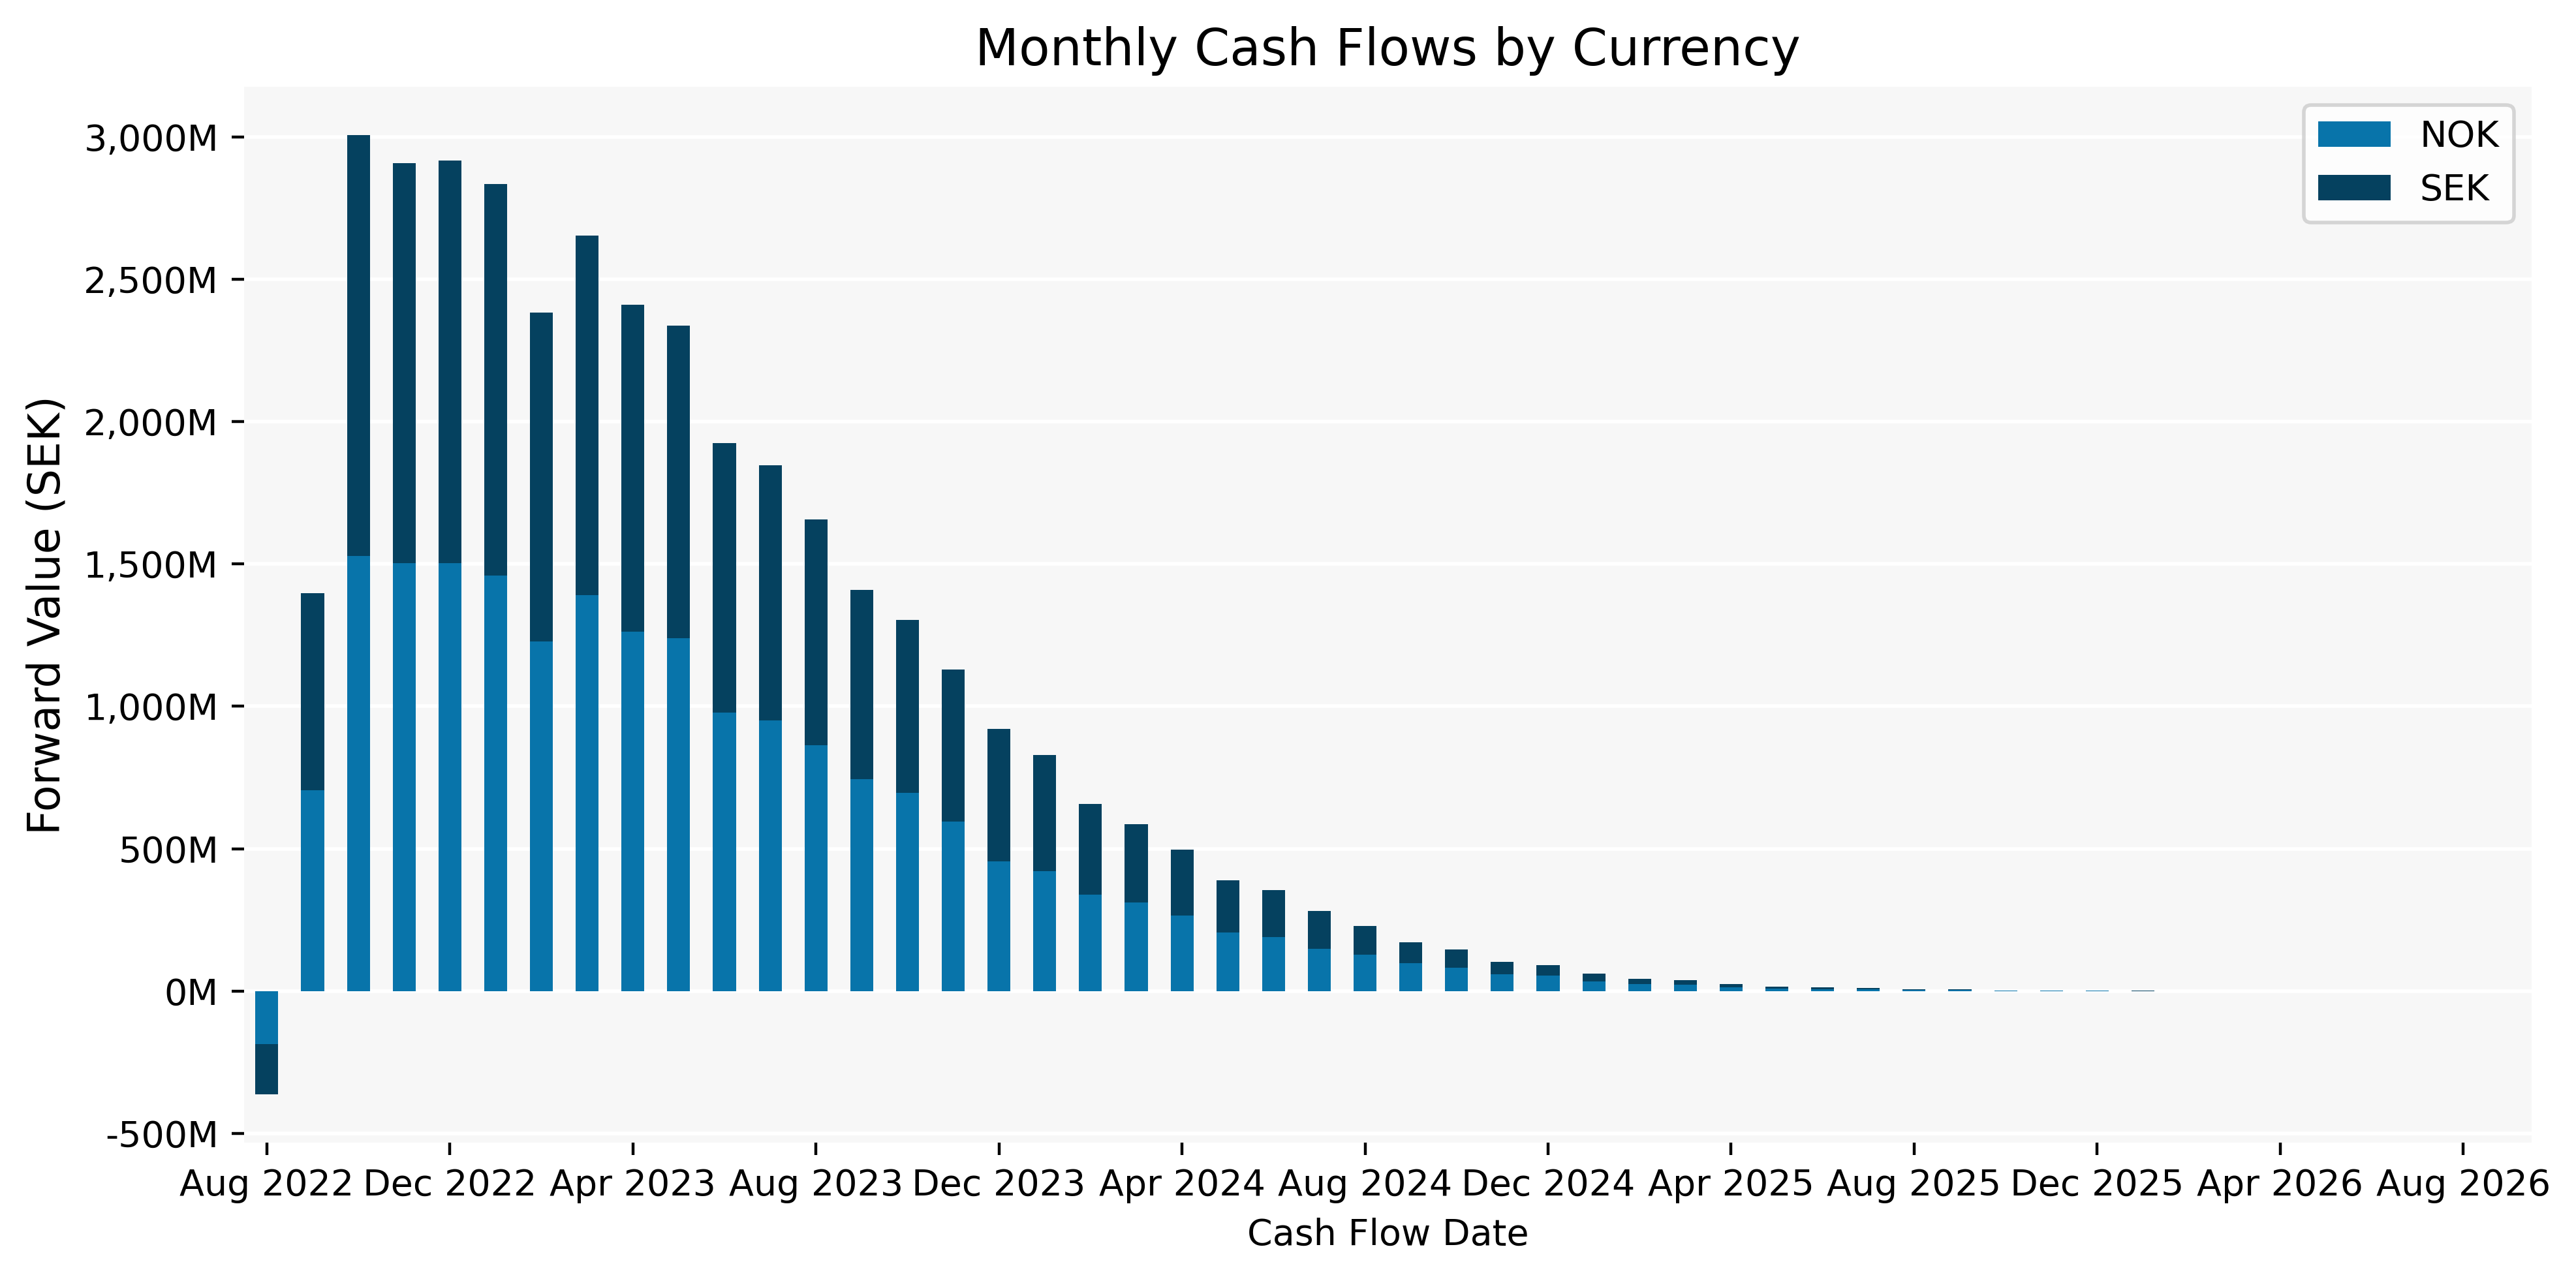

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('png')

def plot_grouped_cash_flows(grouped_cash_flows):
    pivoted = grouped_cash_flows['Forward Value (SEK)'].unstack('Currency')

    date_index = grouped_cash_flows.index.get_level_values(0).unique()
    date_diffs = date_index.to_series().diff().value_counts().idxmax()

    is_daily = date_diffs == pd.Timedelta(days=1)

    if is_daily:
        date_format = '%d %b %Y'
        title = "Daily Cash Flows by Currency"
    else:
        date_format = '%b %Y'
        title = "Monthly Cash Flows by Currency"

    pivoted['YearMonth'] = pivoted.index.strftime(date_format)

    colors = ['#0874aa', '#05415f']

    ax = pivoted.plot(x="YearMonth", kind='bar', stacked=True, figsize=(10, 5), color=colors, zorder=2)
    ax.figure.dpi = 400
    
    ax.set_xlabel("Cash Flow Date", fontsize=10)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel("Forward Value (SEK)", fontsize=12)

    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(fontsize=10)

    ax.yaxis.grid(True, color='#FFFFFF',  linewidth=1, zorder=1)
    ax.xaxis.grid(False)
    
    locs, labels = plt.xticks()
    plt.xticks(locs[::4], labels[::4])
    
    ax.set_facecolor('#F7F7F7')
    ax.figure.set_facecolor('white')
    
    formatter = mticker.FuncFormatter(lambda x, pos: '{:,.0f}M'.format(x/1e6))

    ax.yaxis.set_major_formatter(formatter)
    
    for spine in ax.spines.values():
        spine.set_visible(False)

    legend = ax.legend(frameon=True)
    legend.get_frame().set_facecolor('#FFFFFF')

    plt.tight_layout()
    plt.show()
    
    
plot_grouped_cash_flows(grouped_by_month_per_currency)

##### Cash Flows per Day
Cash flows per day can be graphed for a specific month. The cash flow DataFrame is filtered and then grouped per day.

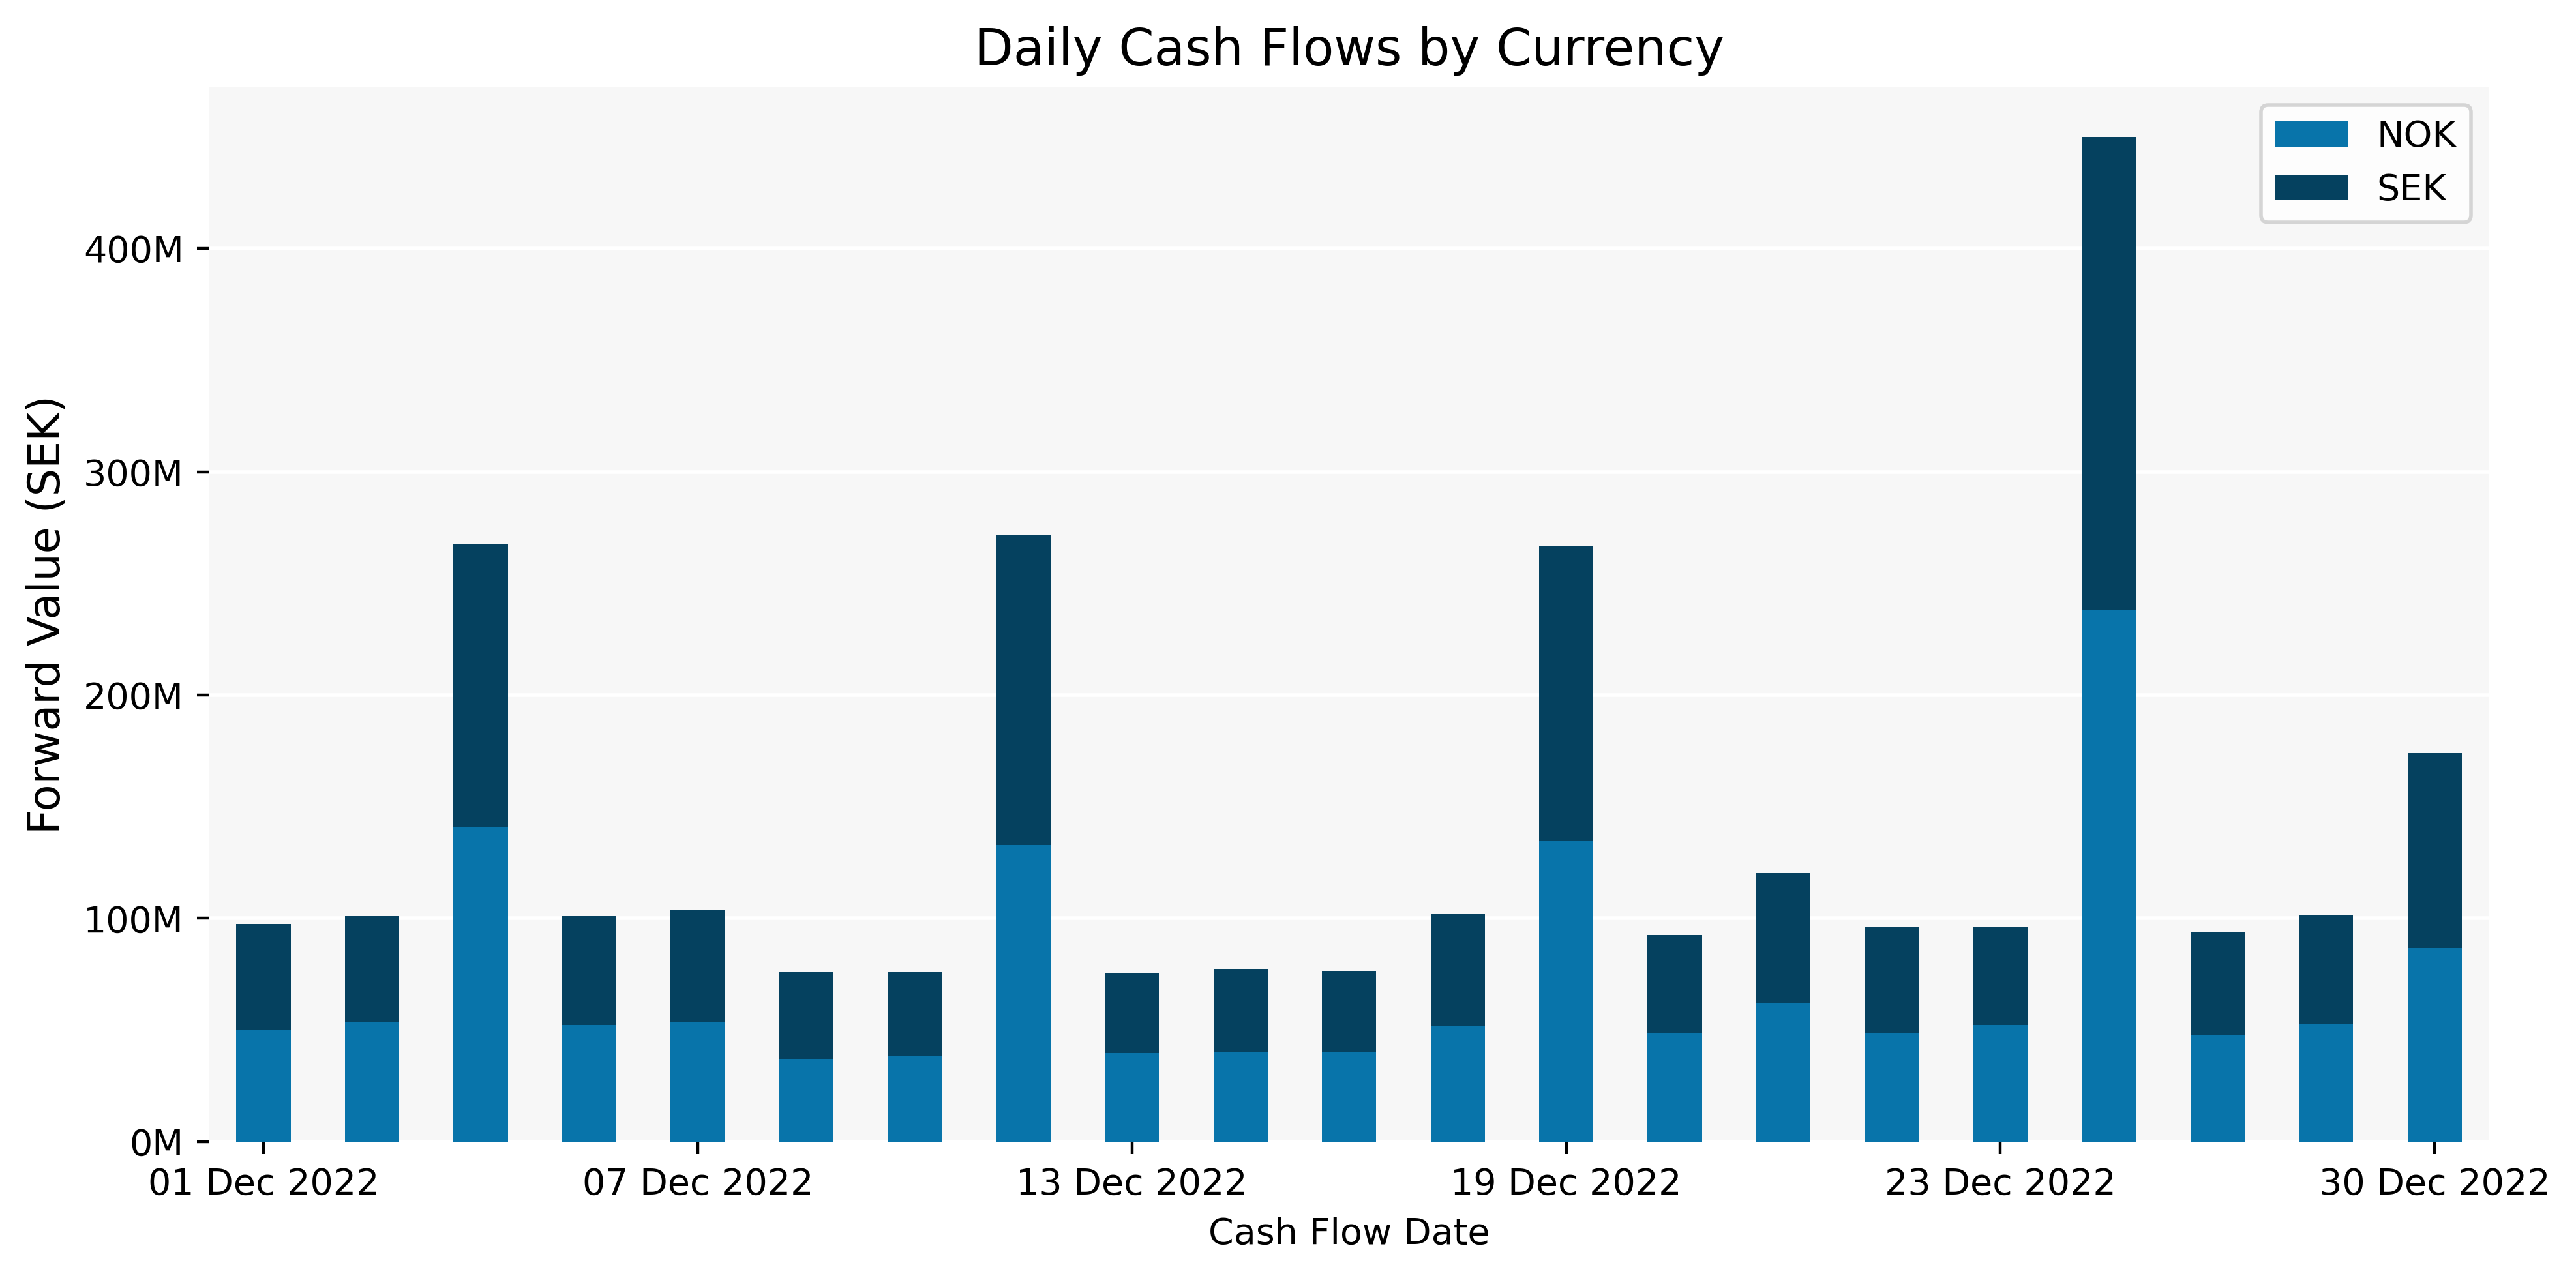

In [17]:
grouped_by_day_per_currency = combined_df[combined_df['Pay'].dt.to_period("M") == '2022-12'].groupby([pd.Grouper(key='Pay', freq='D'), 'Currency']).sum()

plot_grouped_cash_flows(grouped_by_day_per_currency)

##### Heatmap of Risks
The monthly aggregated risks can be visualized using a heatmap to quickly identify pain-points.

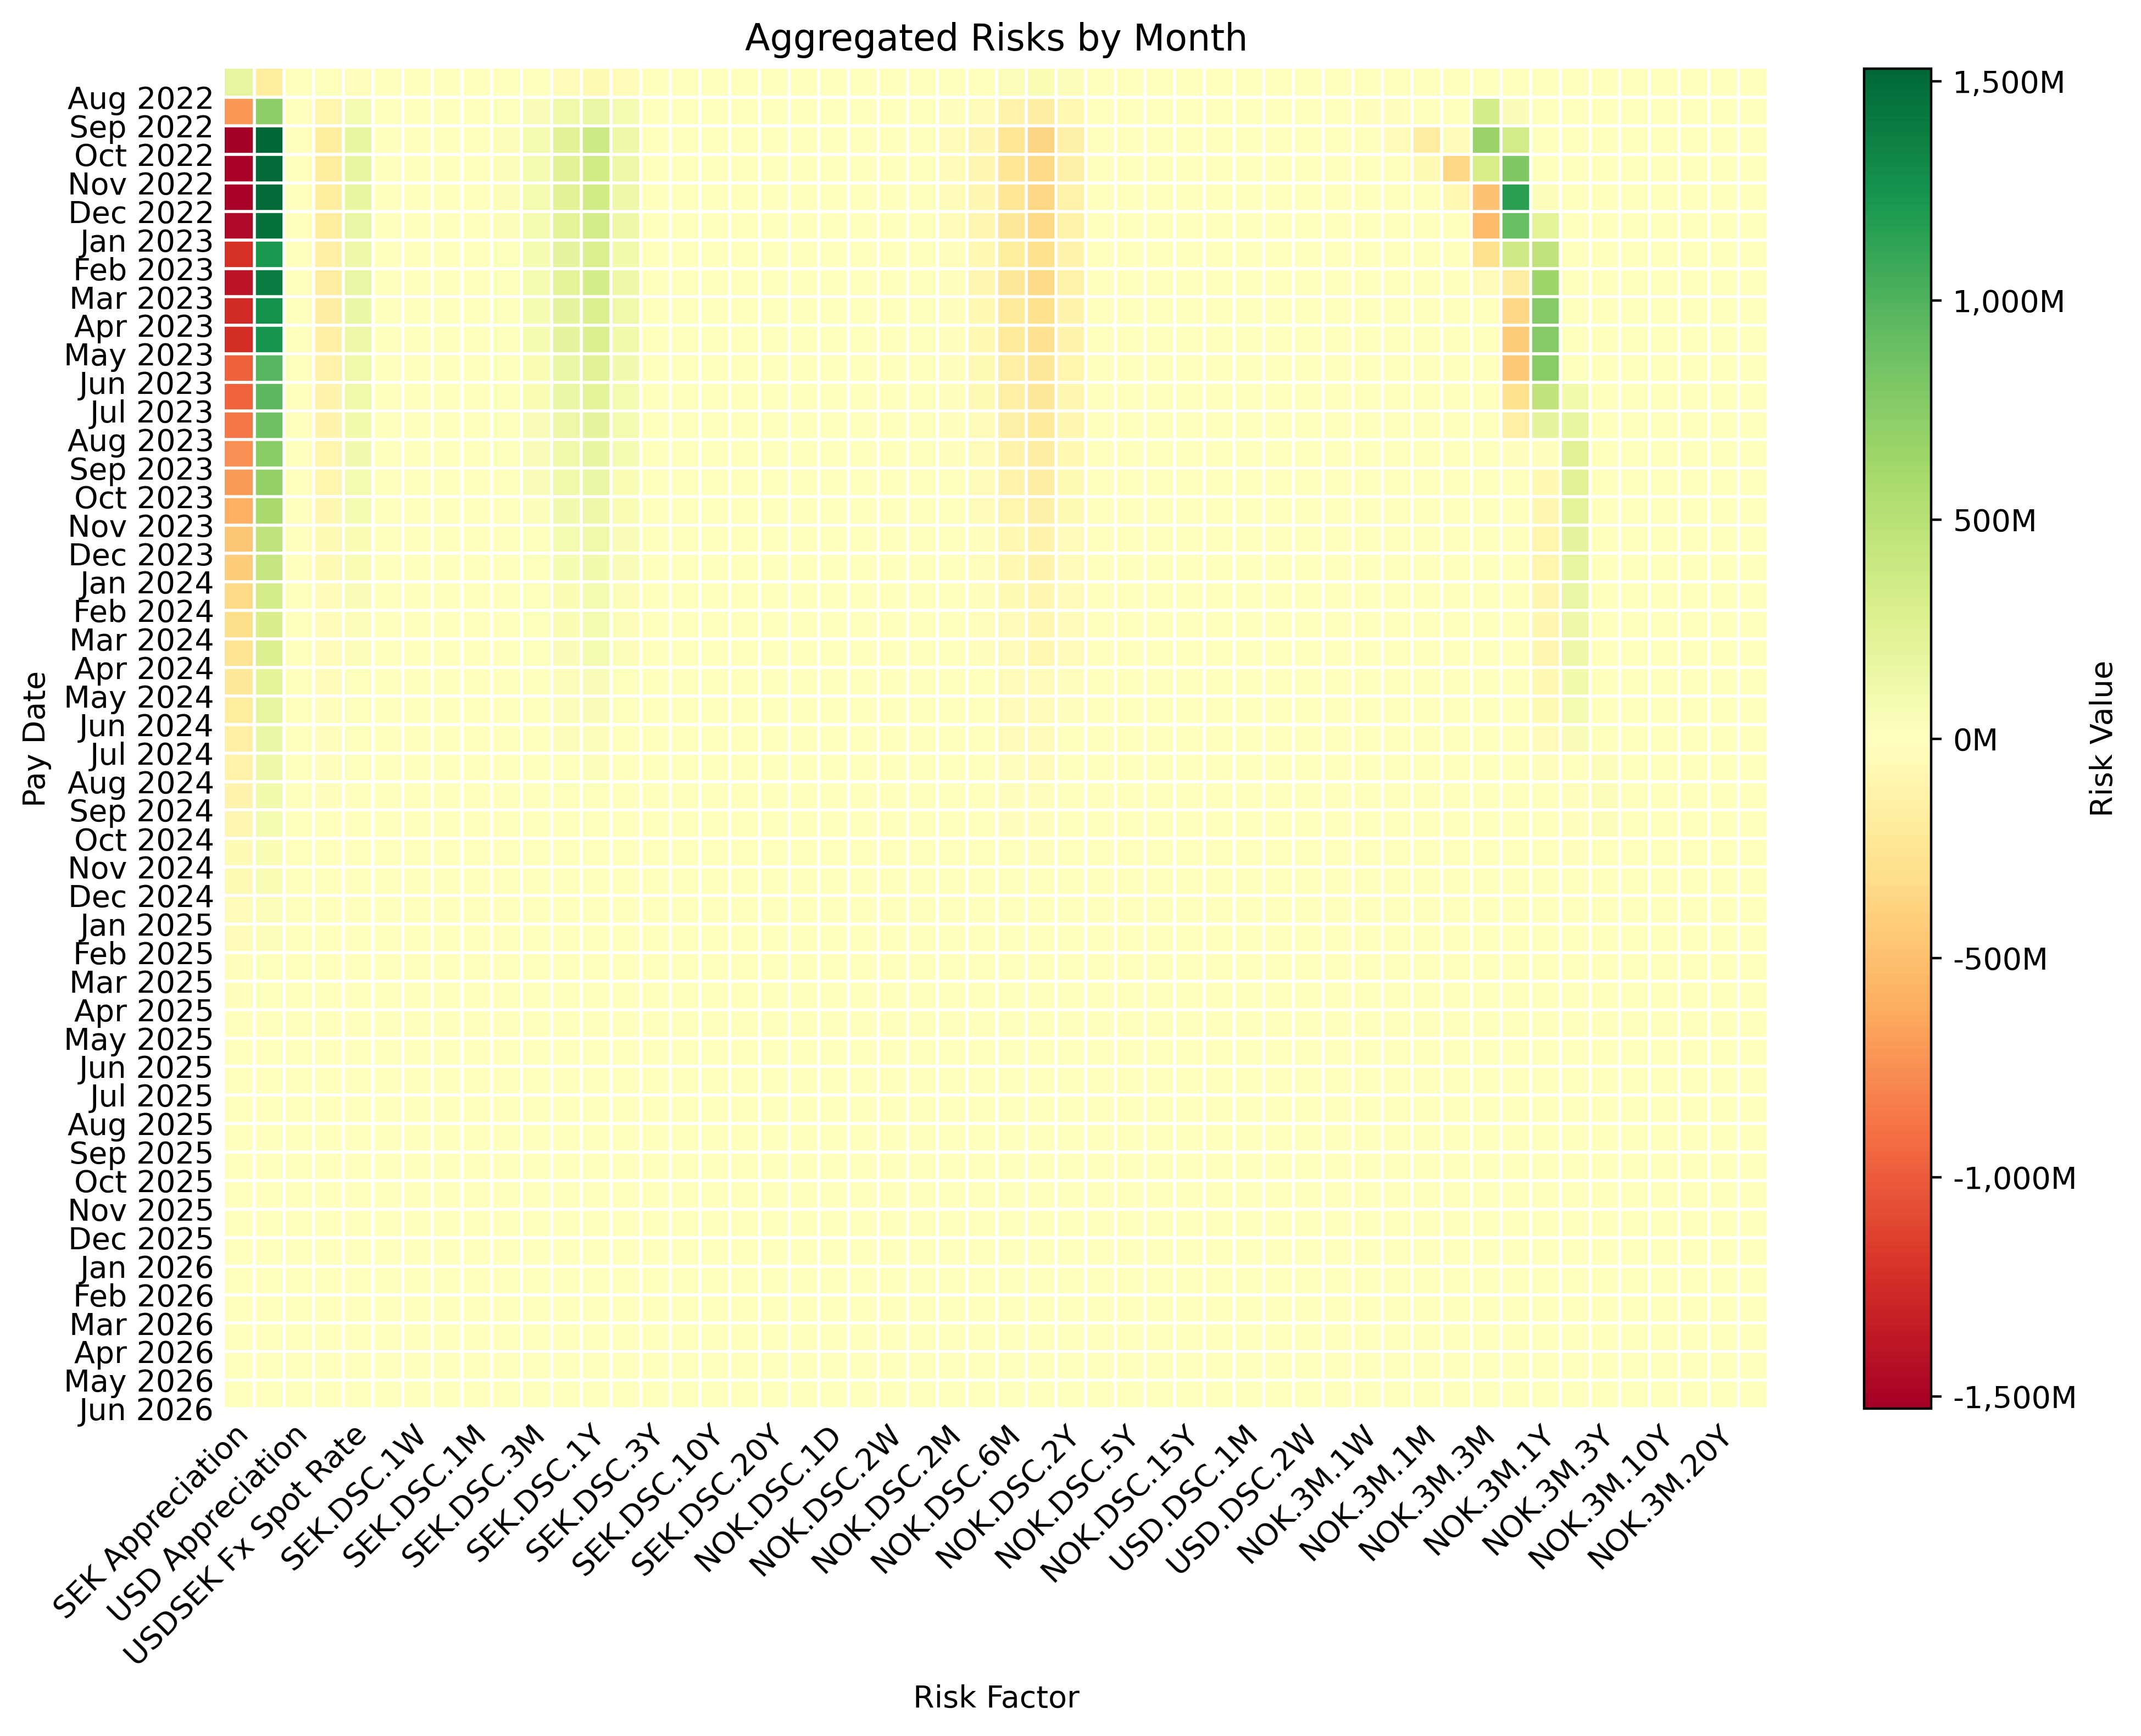

In [18]:
from matplotlib.ticker import FuncFormatter

grouped_by_month.index = pd.to_datetime(grouped_by_month.index, format='%b/%Y')

formatted_dates = grouped_by_month.index.strftime('%b %Y')

heatmap_data = grouped_by_month.iloc[:, 1:]

fig, ax = plt.subplots(figsize=(10, 8))
ax.figure.dpi = 400

cax = ax.imshow(heatmap_data, cmap="RdYlGn", aspect='auto')

xticks = np.arange(len(heatmap_data.columns))+ 0.5
xlabels = [heatmap_data.columns[i] if i % 2 == 0 else '' for i in range(len(heatmap_data.columns))]

ax.set_xticks(xticks, minor=False)
ax.set_yticks(np.arange(len(formatted_dates)) + 0.5, minor=False)
ax.grid(which='major', color='white', linestyle='-', linewidth=1)
ax.tick_params(which='both', size=0, labelsize=10)
ax.set_yticklabels(formatted_dates)
ax.set_xticklabels(xlabels, rotation=45, ha='right')
ax.set_title('Aggregated Risks by Month')
ax.set_xlabel('Risk Factor')
ax.set_ylabel('Pay Date')

formatter = mticker.FuncFormatter(lambda x, pos: '{:,.0f}M'.format(x/1e6))

cbar = fig.colorbar(cax, label='Risk Value', format=FuncFormatter(formatter))
cbar.ax.tick_params(labelsize=10)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()